In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.random.set_seed(1234)
tf.compat.v1.disable_eager_execution()

In [3]:
df = pd.read_csv('../dataset/ACI.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,03/01/2010,98.045508,98.045508,95.983992,96.857516,96.857516,2.620134e+05
1,04/01/2010,97.346689,105.033701,97.346689,103.251712,103.251712,1.452593e+06
2,05/01/2010,105.033701,105.068642,100.561258,102.587834,102.587834,5.914262e+05
3,06/01/2010,102.972184,112.056834,102.797479,111.462838,111.462838,1.436137e+06
4,07/01/2010,112.056834,114.293056,109.610967,112.965299,112.965299,1.227785e+06


In [4]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.209869
1,0.223901
2,0.222444
3,0.241921
4,0.245218


## Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [5]:
test_size = 300
simulation_size = 3

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((2454, 7), (2154, 1), (300, 1))

In [6]:
def position_encoding(inputs):
    T = tf.shape(input=inputs)[1]
    repr_dim = inputs.get_shape()[-1]
    pos = tf.reshape(tf.range(0.0, tf.cast(T, dtype=tf.float32), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(input=inputs)[0], 1, 1])

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(x=inputs, axes=[-1], keepdims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.compat.v1.get_variable('gamma', params_shape, tf.float32, tf.compat.v1.ones_initializer())
    beta = tf.compat.v1.get_variable('beta', params_shape, tf.float32, tf.compat.v1.zeros_initializer())
    return gamma * normalized + beta

def cnn_block(x, dilation_rate, pad_sz, hidden_dim, kernel_size):
    x = layer_norm(x)
    pad = tf.zeros([tf.shape(input=x)[0], pad_sz, hidden_dim])
    x =  tf.compat.v1.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
                          filters = hidden_dim,
                          kernel_size = kernel_size,
                          dilation_rate = dilation_rate)
    x = x[:, :-pad_sz, :]
    x = tf.nn.relu(x)
    return x

class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        kernel_size = 3,
        n_attn_heads = 16,
        dropout = 0.9,
    ):
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))

        encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
        encoder_embedded += position_encoding(encoder_embedded)

        e = tf.identity(encoder_embedded)
        for i in range(num_layers):
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate
            with tf.compat.v1.variable_scope('block_%d'%i):
                encoder_embedded += cnn_block(encoder_embedded, dilation_rate,
                                              pad_sz, size_layer, kernel_size)

        encoder_output, output_memory = encoder_embedded, encoder_embedded + e
        g = tf.identity(encoder_embedded)

        for i in range(num_layers):
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate
            with tf.compat.v1.variable_scope('decode_%d'%i):
                attn_res = h = cnn_block(encoder_embedded, dilation_rate,
                                         pad_sz, size_layer, kernel_size)

            C = []
            for j in range(n_attn_heads):
                h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
                g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
                zu_ = tf.compat.v1.layers.dense(
                    encoder_output, size_layer // n_attn_heads
                )
                ze_ = tf.compat.v1.layers.dense(output_memory, size_layer // n_attn_heads)

                d = tf.compat.v1.layers.dense(h_, size_layer // n_attn_heads) + g_
                dz = tf.matmul(d, tf.transpose(a=zu_, perm=[0, 2, 1]))
                a = tf.nn.softmax(dz)
                c_ = tf.matmul(a, ze_)
                C.append(c_)

            c = tf.concat(C, 2)
            h = tf.compat.v1.layers.dense(attn_res + c, size_layer)
            h = tf.nn.dropout(h, rate = 1 - (dropout))
            encoder_embedded += h

        encoder_embedded = tf.sigmoid(encoder_embedded[-1])
        self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)
        self.cost = tf.reduce_mean(input_tensor=tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [7]:
num_layers = 1
size_layer = 128*4
timestamp = test_size
epoch = 10
dropout_rate = 0.8
future_day = test_size
learning_rate = 5e-5

In [8]:
def forecast():
    tf.compat.v1.get_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1],
        dropout = dropout_rate
    )
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {modelnn.X: batch_x, modelnn.Y: batch_y},
            )
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [9]:

results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())
    tf.compat.v1.reset_default_graph()

simulation 1
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.


train loop: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it, acc=72.2, cost=0.148]


simulation 2


train loop: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it, acc=74.5, cost=0.123]


simulation 3


train loop: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it, acc=75.6, cost=0.11]


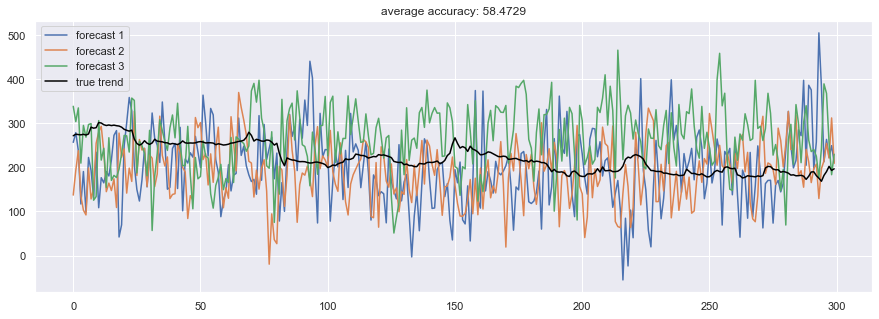

In [10]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()